<a href="https://colab.research.google.com/github/bambrah-tk/tuw-python-2022WS/blob/main/Corruption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%%capture
!type -p curl >/dev/null || sudo apt install curl -y
!curl -fsSL https://cli.github.com/packages/githubcli-archive-keyring.gpg | sudo dd of=/usr/share/keyrings/githubcli-archive-keyring.gpg \
&& sudo chmod go+r /usr/share/keyrings/githubcli-archive-keyring.gpg \
&& echo "deb [arch=$(dpkg --print-architecture) signed-by=/usr/share/keyrings/githubcli-archive-keyring.gpg] https://cli.github.com/packages stable main" | sudo tee /etc/apt/sources.list.d/github-cli.list > /dev/null \
&& sudo apt update \
&& sudo apt install gh -y

In [8]:
import os
from getpass import getpass
os.environ['GH_TOKEN'] = getpass('GitHub token')

GitHub token··········


In [9]:
!gh repo clone nikoczernin/corruption

Cloning into 'corruption'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 206 (delta 52), reused 166 (delta 27), pack-reused 0
Receiving objects: 100% (206/206), 2.95 MiB | 13.27 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [10]:
!cp -r corruption/* ./ && rm -rf corruption/ .git notes.ipynb Corruption.ibynp

In [11]:
import pandas as pd
import numpy as np

from IPython.display import clear_output

import os

import requests
import zipfile
import io
import re

import seaborn as sns
import matplotlib.pyplot as plt

import openpyxl

from helpers import *

# Datasets 


## Corruption dataset 1: 
#### CPI (Corruption perception index)  
Source: Transparency International  
higher > better  
https://data.europa.eu/data/datasets/ojmmqokcgkay4cdfkwdavw?locale=en

In [12]:
missing_codes = pd.read_csv("data/missing country codes.csv", names=["name", "code"])
missing_codes = dict(zip(missing_codes.name, missing_codes.code))

In [13]:
def load_cpi(
    url = None,
    region_short=False,
    country_name=False,
    no_download=True
):
    path = "data/cpi"
    if url is not None and not no_download:
        zip_download_extract(url, path)
        
    # get the right folder and add it to path
    folder_pattern = "Full Data Set"
    path = path + "/" + [x for x in os.listdir(path) if folder_pattern in x][0]
    # get the right file and add it to path
    filename_pattern = "GlobalResults&Trends.xlsx"
    path = path + "/" +  [x for x in os.listdir(path) if filename_pattern in x][0]

    # load the file
    df = pd.read_excel(path, sheet_name=1, header=2)
    df = df.rename(columns={"Country / Territory":"country_name", "ISO3":"country_code", "Region":"region_short"})

    # create a dict to rename the cpi columns to have a suffix
    cpi_columns_renamer = {c:f"cpi_{c.split()[2]}" for c in df.columns if "score" in c.lower()}
    df = df.rename(columns=cpi_columns_renamer) # apply the renaming dict
    cpi_columns = list(cpi_columns_renamer.values()) # list of cpi column names

    # select only the wanted columns
    df = df[["country_name", "country_code", "region_short"] + cpi_columns]
    
    # turn the cpi columns into floats
    df[cpi_columns] = df[cpi_columns].astype("float")
    
    # potentially drop some again :)
    if not country_name: df = df.drop("country_name", 1)
    if not region_short: df = df.drop("region_short", 1)
    return df

cpi = load_cpi(url = "https://images.transparencycdn.org/images/CPI-2021-Full-Data-Set.zip")
cpi = pd.wide_to_long(cpi, "cpi", "country_code", "year", sep="_")
cpi

<ipython-input-13-a7e19cf4b0c6>:34: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if not country_name: df = df.drop("country_name", 1)
<ipython-input-13-a7e19cf4b0c6>:35: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if not region_short: df = df.drop("region_short", 1)


,,cpi
country_code,year,
DNK,2021,88.0
NZL,2021,88.0
FIN,2021,88.0
SGP,2021,85.0
SWE,2021,85.0
...,...,...
VEN,2012,19.0
SYR,2012,26.0
SOM,2012,8.0


## Corruption dataset 2: 
#### Corruption Index  
Source: World Bank  
higher value > less corrupt  
This was different from the other World Bank sources, so I had to download it differently  
https://databank.worldbank.org/reports.aspx?Id=1655f855&Report_Name=Corruption#

In [14]:
def load_world_bank_corruption_index(
            path="data/misc", 
            prefix=None,
            country_name=False, 
            country_code=True,
            pivot_longer=True
):
    # load the datafile
    print(path)
    with open(path, "r") as f:
        data = f.readlines() 
    # PreProcessing
    # each row is a country
    # columns go: Country Name, Country Code, Series Name, Series Code, and then data ...
    # each data column is named YYYY [some stuff]
    # NAs are ".."
    # single header row in row 1, some unnecessary metadata in bottom rows
    columns = data[0].split(",")
    columns.pop(2)
    columns.pop(2)
    if prefix is not None: prefix += "_"
    columns = columns[:2] + [prefix + c[:4] for c in columns[2:]]
    value_columns = columns[2:]
    
    data = data[1:]
    
    data = [line.split(",Control of Corruption: Estimate,CC.EST,") for line in data]
    data = [[line[0][:-4], line[0][-3:]] + line[1].split(",") for line in data if len(line)==2]
    
    # create dataframe
    df = pd.DataFrame(data, columns=columns)
    # rename some cols
    df = df.rename(columns={"Country Name": "country_name", "Country Code": "country_code"})
    # drop unwanted columns (decided in args)
    if not country_name: df = df.drop("country_name", 1)
    if not country_code: df = df.drop("country_code", 1)
    
    # last row has "\n" at its tail
    df[value_columns[-1]] = df[value_columns[-1]].apply(lambda x: x.replace("\n", ""))
    
    # settings NANs
    df = df.replace("..", np.nan)
    df = df.replace("..", np.nan)
    # turn value columns into floats
    df[value_columns] = df[value_columns].astype("float")
    
    if pivot_longer and prefix is not None:
        df = pd.wide_to_long(df, prefix[:-1], "country_code", "year", sep="_")
        
    return df

    
    

ci = load_world_bank_corruption_index (
    path="data/ci_wb/P_Corruption/02069cc0-2f0f-4337-bffa-667860f81dfb_Data.csv",
    prefix="ci"
)
ci

data/ci_wb/P_Corruption/02069cc0-2f0f-4337-bffa-667860f81dfb_Data.csv


<ipython-input-14-308baa6f0977>:35: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if not country_name: df = df.drop("country_name", 1)


,,ci
country_code,year,
AFG,1996,-1.291705
ALB,1996,-0.893903
DZA,1996,-0.566741
ASM,1996,NaN
AND,1996,1.318143
...,...,...
VIR,2021,0.036268
PSE,2021,-0.738600
YEM,2021,-1.651691


Max:  
Ich würde gerne folgende dinge als mögliche indikatoren von korruption ausprobieren: Inflation, Staatsverschuldung, Wirtschaft (GDP per capita), Entwicklungsstatus des landes, Region (kontinent oder subkontinent)  
zu staatsschulden, inflation und wirtschaftsleistung gibt es datasets von derselben seite wie der korruptionsindex was uns viel arbeit ersparen kann das campaign finance data set ist allerdings für alle länder weltweit.  
weiters hab ich ein dataset gefunden mit super viel information über campaign finance, also zb wieviele spenden eine partei annehmen darf oder wieviel sie während des wahlkampfes ausgeben darf. Mich würde interessieren ob wir das nicht auch mit reinnehmen könnten.

### Source: World Bank

*das hier sind alles World Bank Datenlinks. die könnten theoretisch alle in dict wb_datasets das in der nächsten Cell definiert wird eingetragen werden, dann werden die Daten automatisch geladen*

https://data.worldbank.org/indicator  
the listed links are directly to the CSV

Dataset 1: GDP  (in bn $)
https://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.CD?downloadformat=csv  
  
Dataset 2: Inflation  
https://data.worldbank.org/indicator/NY.GDP.DEFL.KD.ZG?view=chart
  
Dataset 3: Central gov. debt  (percent of gdp)
https://api.worldbank.org/v2/en/indicator/GC.DOD.TOTL.GD.ZS?downloadformat=csv

Primary completion rate, total (% of relevant age group)  
https://api.worldbank.org/v2/en/indicator/SE.PRM.CMPT.ZS?downloadformat=csv

Net migration (immigrants minus emigrants)  
https://api.worldbank.org/v2/en/indicator/SM.POP.NETM?downloadformat=csv

Net official development assistance (ODA)  
https://api.worldbank.org/v2/en/indicator/DT.ODA.ODAT.GN.ZS?downloadformat=csv

Real interest rate (%)  
https://api.worldbank.org/v2/en/indicator/FR.INR.RINR?downloadformat=csv  

Grants, excluding technical cooperation  in $
https://api.worldbank.org/v2/en/indicator/BX.GRT.EXTA.CD.WD?downloadformat=csv  
(unsure about this one ... https://data.worldbank.org/indicator/BX.GRT.EXTA.CD.WD?view=chart) 

Technical cooperation grants (BoP, current US$)  
https://api.worldbank.org/v2/en/indicator/BX.GRT.TECH.CD.WD?downloadformat=csv  

Pregnant women receiving prenatal care  
https://api.worldbank.org/v2/en/indicator/SH.STA.ANVC.ZS?downloadformat=csv  

School enrollment, primary and secondary (gross), gender parity index (ratio of girls to boys) 
https://api.worldbank.org/v2/en/indicator/SE.ENR.PRSC.FM.ZS?downloadformat=csv  

Poverty headcount ratio at $2.15 a day  (percent)
https://api.worldbank.org/v2/en/indicator/SI.POV.DDAY?downloadformat=csv  

Access to electricity (% of population)  
https://api.worldbank.org/v2/en/indicator/EG.ELC.ACCS.ZS?downloadformat=csv  

Foreign direct investment, net inflows
https://data.worldbank.org/indicator/BX.KLT.DINV.CD.WD?view=chart
https://api.worldbank.org/v2/en/indicator/BX.KLT.DINV.CD.WD?downloadformat=csv  

Government expenditure on education, total (% of GDP)  
https://api.worldbank.org/v2/en/indicator/SE.XPD.TOTL.GD.ZS?downloadformat=csv  

Literacy rate, adult total (% of people ages 15 and above)  
https://api.worldbank.org/v2/en/indicator/SE.ADT.LITR.ZS?downloadformat=csv

Government expenditure on education, total (% of government expenditure)  
https://api.worldbank.org/v2/en/indicator/SE.XPD.TOTL.GB.ZS?downloadformat=csv  

Unemployment, total (% of total labor force) (modeled ILO estimate)  
https://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv

School enrollment, tertiary (% gross)  
https://api.worldbank.org/v2/en/indicator/SE.TER.ENRR?downloadformat=csv  

Tax revenue (% of GDP)
https://api.worldbank.org/v2/en/indicator/GC.TAX.TOTL.GD.ZS?downloadformat=csv

Strength of legal rights index (0=weak to 12=strong)  
https://api.worldbank.org/v2/en/indicator/IC.LGL.CRED.XQ?downloadformat=csv  
https://data.worldbank.org/indicator/IC.LGL.CRED.XQ?view=chart  

Investment in water and sanitation with private participation (current US$)  
https://api.worldbank.org/v2/en/indicator/IE.PPI.WATR.CD?downloadformat=csv  
https://data.worldbank.org/indicator/IE.PPI.WATR.CD?view=chart  

Income share held by highest 10%  
https://api.worldbank.org/v2/en/indicator/SI.DST.10TH.10?downloadformat=csv  

Income share held by lowest 10%  
https://api.worldbank.org/v2/en/indicator/SI.DST.FRST.10?downloadformat=csv  

Gini index (might be redundant or even make other vars redundant)  
https://api.worldbank.org/v2/en/indicator/SI.POV.GINI?downloadformat=csv  

Secure Internet servers (per 1 million people)  
https://api.worldbank.org/v2/en/indicator/IT.NET.SECR.P6?downloadformat=csv  

Investment in transport with private participation (current US$)  
https://api.worldbank.org/v2/en/indicator/IE.PPI.TRAN.CD?downloadformat=csv

Intentional homicides (per 100,000 people)  
https://api.worldbank.org/v2/en/indicator/VC.IHR.PSRC.P5?downloadformat=csv

Military expenditure (% of GDP)  
https://api.worldbank.org/v2/en/indicator/MS.MIL.XPND.GD.ZS?downloadformat=csv  

Research and development expenditure (% of GDP)  
https://api.worldbank.org/v2/en/indicator/GB.XPD.RSDV.GD.ZS?downloadformat=csv  

Population  
https://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv



In [15]:
# world_bank_datasets
wb_datasets = [
"population",
"https://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv",
    
"gdp",
"https://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.CD?downloadformat=csv",

"inflation",
"https://api.worldbank.org/v2/en/indicator/NY.GDP.DEFL.KD.ZG?downloadformat=csv",

"gov_debt_percent",
"https://api.worldbank.org/v2/en/indicator/GC.DOD.TOTL.GD.ZS?downloadformat=csv",

"primary_completion_percent",
"https://api.worldbank.org/v2/en/indicator/SE.PRM.CMPT.ZS?downloadformat=csv",

"migration",
"https://api.worldbank.org/v2/en/indicator/SM.POP.NETM?downloadformat=csv",

"development_assistance_percent",
"https://api.worldbank.org/v2/en/indicator/DT.ODA.ODAT.GN.ZS?downloadformat=csv",

"interest_real",
"https://api.worldbank.org/v2/en/indicator/FR.INR.RINR?downloadformat=csv",

"grants_non_tech_abs",
"https://api.worldbank.org/v2/en/indicator/BX.GRT.EXTA.CD.WD?downloadformat=csv",

"grants_tech_abs",
"https://api.worldbank.org/v2/en/indicator/BX.GRT.TECH.CD.WD?downloadformat=csv",

"pregnants_receiving_healthcare",
"https://api.worldbank.org/v2/en/indicator/SH.STA.ANVC.ZS?downloadformat=csv",

"school_fm_ratio",
"https://api.worldbank.org/v2/en/indicator/SE.ENR.PRSC.FM.ZS?downloadformat=csv",

"poverty_percent",
"https://api.worldbank.org/v2/en/indicator/SI.POV.DDAY?downloadformat=csv",

"electricity_access_percent",
"https://api.worldbank.org/v2/en/indicator/EG.ELC.ACCS.ZS?downloadformat=csv",

"foreign_direct_investment_abs",
"https://api.worldbank.org/v2/en/indicator/BX.KLT.DINV.CD.WD?downloadformat=csv",

"education_expenditure_percent",
"https://api.worldbank.org/v2/en/indicator/SE.XPD.TOTL.GD.ZS?downloadformat=csv",

"literacy_percent",
"https://api.worldbank.org/v2/en/indicator/SE.ADT.LITR.ZS?downloadformat=csv",

"unemployment_percent",
"https://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv",

"tertiary_enrollment_percent",
"https://api.worldbank.org/v2/en/indicator/SE.TER.ENRR?downloadformat=csv",

"tax_revenue_percent",
"https://api.worldbank.org/v2/en/indicator/GC.TAX.TOTL.GD.ZS?downloadformat=csv",

"legal_rights_index",
"https://api.worldbank.org/v2/en/indicator/IC.LGL.CRED.XQ?downloadformat=csv",

"water_investment_total_abs",
"https://api.worldbank.org/v2/en/indicator/IE.PPI.WATR.CD?downloadformat=csv",

"wealth_highest_10_percent",
"https://api.worldbank.org/v2/en/indicator/SI.DST.10TH.10?downloadformat=csv",

"wealth_lowest_10_percent",
"https://api.worldbank.org/v2/en/indicator/SI.DST.FRST.10?downloadformat=csv",

"gini",
"https://api.worldbank.org/v2/en/indicator/SI.POV.GINI?downloadformat=csv",

"secure_servers_perml",
"https://api.worldbank.org/v2/en/indicator/IT.NET.SECR.P6?downloadformat=csv",

"transport_investment_abs",
"https://api.worldbank.org/v2/en/indicator/IE.PPI.TRAN.CD?downloadformat=csv",

"murders_p100k",
"https://api.worldbank.org/v2/en/indicator/VC.IHR.PSRC.P5?downloadformat=csv",

"military_expenses_percent",
"https://api.worldbank.org/v2/en/indicator/MS.MIL.XPND.GD.ZS?downloadformat=csv",

"rd_expenses_percent",
"https://api.worldbank.org/v2/en/indicator/GB.XPD.RSDV.GD.ZS?downloadformat=csv"
]


wb_datasets = [{
                "name": wb_datasets[i],
                "url": wb_datasets[i+1]
               } for i in range(0, len(wb_datasets), 2)]
wb_datasets[:3]

[{'name': 'population',
  'url': 'https://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv'},
 {'name': 'gdp',
  'url': 'https://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.CD?downloadformat=csv'},
 {'name': 'inflation',
  'url': 'https://api.worldbank.org/v2/en/indicator/NY.GDP.DEFL.KD.ZG?downloadformat=csv'}]

In [16]:
def load_world_bank_data(
            path="data/misc", 
            url=None,
            full_path=False,
            prefix=None,
            country_name=False, 
            country_code=True,
            pivot_longer=True,
            no_download=False
            ):
    """
    All World Bank Data I viewed so far had the same architecture
    also, the downloads always featured two metadata files and one datafile
    path: either a full file path or just the path to the folder where the data should be
    full_path: indicates whether the path is to a file or just the folder the file is in
    url: if this is not None, the file will be downloaded freshly from the source
    country_name, country_code: if True, the variable will be included in the output object
    suffix: suffix to be added to the value columns (optional)
    """
    
    # online source
    if url is not None and not no_download:
        # do the download
        zip_download_extract(url, path)
        
    # search for the right file
    if not full_path: 
        filename = [f for f in os.listdir(path) if "etadata" not in f and "DS_Store" not in f][0]
        path = f"{path}/{filename}"
            
    # load the datafile

    with open(path, "r") as f:
        data = f.readlines()        
    # PreProcessing
    # in the fifth row the columns are named
    # the first 5 are descriptive things like country code and such
    # from then on it's data, with the year as a colname
    columns = data[4].split(",")
    columns = [c.replace("\"", "") for c in columns][:-1]

    value_columns = [c for c in columns if c.isnumeric()]

    # the real data starts on row 6
    data = data[5:]
    # we split with "," and not with , because some countries have commas in their name
    data = [row.split('\",\"') for row in data]
    # creating a pandas df

    df = pd.DataFrame(data, columns=columns)
    # removing the string residuals in the first and last col
    df.iloc[:,-1] = df.iloc[:,-1].apply(lambda x: x[:-3])
    df.iloc[:,0] = df.iloc[:,0].apply(lambda x: x[1:])

    # renaming columns
    df = df.rename(columns={"Country Name": "country_name", "Country Code": "country_code"})

    # dropping the unnecessary ones
    df = df.drop(["Indicator Name", "Indicator Code"], 1)
    if not country_name:
        df = df.drop("country_name", 1)
    if not country_code:
        df = df.drop("country_code", 1)
        
    # turning value columns from strings to floats
    df = df.replace("", np.nan)
    df[value_columns] = df[value_columns].astype("float")
    
    # adding a suffix to the yearly data column names
    # only do this, if a suffix has been provided
    if prefix is not None:
        value_column_translater = {name: f"{prefix}_{name}" for name in value_columns}
        df = df.rename(columns=value_column_translater)
    
    if pivot_longer and prefix is not None:
        df = pd.wide_to_long(df, prefix, "country_code", "year", sep="_")
        
    return df



In [17]:
# loading the data
for dataset in wb_datasets:
    dataset["data"] = load_world_bank_data(path = f"data/world_bank/{dataset['name']}",
                                          prefix = dataset['name'],
                                          url = dataset['url'],
                                          no_download=True
                                          )


<ipython-input-16-c189167c3fa2>:59: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(["Indicator Name", "Indicator Code"], 1)
<ipython-input-16-c189167c3fa2>:61: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop("country_name", 1)


In [18]:
# joining the cpi and the world bank datasets
full = cpi.copy()
full = full.join(ci, how="outer")

for x in wb_datasets:
    full = full.join(x["data"], how="outer")


In [19]:
full


cpi        ci  population          gdp   inflation  \
country_code year                                                        
ABW          1960   NaN       NaN     54608.0          NaN         NaN   
             1961   NaN       NaN     55811.0          NaN         NaN   
             1962   NaN       NaN     56682.0          NaN         NaN   
             1963   NaN       NaN     57475.0          NaN         NaN   
             1964   NaN       NaN     58178.0          NaN         NaN   
...                 ...       ...         ...          ...         ...   
ZWE          2017  22.0 -1.281081  14751101.0  1192.107012    3.056905   
             2018  22.0 -1.227581  15052184.0  2269.177012  200.769578   
             2019  24.0 -1.273280  15354608.0  1421.868596  225.394648   
             2020  24.0 -1.289440  15669666.0  1372.696674  604.945864   
             2021  23.0 -1.257897  15993524.0  1773.920411  113.294981   

                   gov_debt_percent  primary_completion_percent  migration  \
country_code year                                                            
ABW          1960               NaN                         NaN        0.0   
             1961               NaN                         NaN     -569.0   
             1962               NaN                         NaN     -609.0   
             1963               NaN                         NaN     -646.0   
             1964               NaN                         NaN     -684.0   
...                             ...                         ...        ...   
ZWE          2017               NaN                   95.476372   -59918.0   
             2018               NaN                   92.195152   -59918.0   
             2019               NaN                   88.508812   -59918.0   
             2020               NaN                   90.017349   -29955.0   
             2021               NaN                   84.818619   -25005.0   

                   development_assistance_percent  interest_real  ...  \
country_code year                                                 ...   
ABW          1960                             NaN            NaN  ...   
             1961                             NaN            NaN  ...   
             1962                             NaN            NaN  ...   
             1963                             NaN            NaN  ...   
             1964                             NaN            NaN  ...   
...                                           ...            ...  ...   
ZWE          2017                        4.654684       3.742846  ...   
             2018                        2.375721     -64.380817  ...   
             2019                        3.921986     -64.295151  ...   
             2020                        4.679008     -81.132121  ...   
             2021                             NaN     -31.795551  ...   

                   legal_rights_index  water_investment_total_abs  \
country_code year                                                   
ABW          1960                 NaN                         NaN   
             1961                 NaN                         NaN   
             1962                 NaN                         NaN   
             1963                 NaN                         NaN   
             1964                 NaN                         NaN   
...                               ...                         ...   
ZWE          2017                 5.0                         NaN   
             2018                 5.0                         NaN   
             2019                 6.0                         NaN   
             2020                 NaN                         NaN   
             2021                 NaN                         NaN   

                   wealth_highest_10_percent  wealth_lowest_10_percent  gini  \
country_code year                                                              
ABW          1960                 

In [20]:
# here I make another version of the full dataframe, where either the CPI or the CI are not NA
df = full[~full.cpi.isna() | ~full.ci.isna()]
df

cpi        ci  population           gdp   inflation  \
country_code year                                                         
ABW          2004   NaN  1.165965     93540.0  24104.646177    2.817214   
             2005   NaN  1.269663     94483.0  24975.673257    5.062491   
             2006   NaN  1.251313     95606.0  25833.445623    3.485226   
             2007   NaN  1.261871     96787.0  27665.426465    5.157937   
             2008   NaN  1.276775     97996.0  29011.559245    4.264063   
...                 ...       ...         ...           ...         ...   
ZWE          2017  22.0 -1.281081  14751101.0   1192.107012    3.056905   
             2018  22.0 -1.227581  15052184.0   2269.177012  200.769578   
             2019  24.0 -1.273280  15354608.0   1421.868596  225.394648   
             2020  24.0 -1.289440  15669666.0   1372.696674  604.945864   
             2021  23.0 -1.257897  15993524.0   1773.920411  113.294981   

                   gov_debt_percent  primary_completion_percent  migration  \
country_code year                                                            
ABW          2004               NaN                   90.559898      315.0   
             2005               NaN                   88.197968      579.0   
             2006               NaN                   93.186119      569.0   
             2007               NaN                   95.588242      621.0   
             2008               NaN                   95.133034      666.0   
...                             ...                         ...        ...   
ZWE          2017               NaN                   95.476372   -59918.0   
             2018               NaN                   92.195152   -59918.0   
             2019               NaN                   88.508812   -59918.0   
             2020               NaN                   90.017349   -29955.0   
             2021               NaN                   84.818619   -25005.0   

                   development_assistance_percent  interest_real  ...  \
country_code year                                                 ...   
ABW          2004                             NaN       6.596937  ...   
             2005                             NaN       5.651407  ...   
             2006                             NaN       5.812205  ...   
             2007                             NaN       4.984943  ...   
             2008                             NaN       5.980907  ...   
...                                           ...            ...  ...   
ZWE          2017                        4.654684       3.742846  ...   
             2018                        2.375721     -64.380817  ...   
             2019                        3.921986     -64.295151  ...   
             2020                        4.679008     -81.132121  ...   
             2021                             NaN     -31.795551  ...   

                   legal_rights_index  water_investment_total_abs  \
country_code year                                                   
ABW          2004                 NaN                         NaN   
             2005                 NaN                         NaN   
             2006                 NaN                         NaN   
             2007                 NaN                         NaN   
             2008                 NaN                         NaN   
...                               ...                         ...   
ZWE          2017                 5.0                         NaN   
             2018                 5.0                         NaN   
             2019                 6.0                         NaN   
             2020                 NaN                         NaN   
             2021                 NaN                         NaN   

                   wealth_highest_10_percent  wealth_lowest_10_percent  gini  \
country_code year                                                              
ABW          2004    

## Dataset 4: Country metadata – regions and income group
Comes with every dataset downloaded from World Bank
Specific source for this one: https://api.worldbank.org/v2/en/indicator/GC.DOD.TOTL.GD.ZS?downloadformat=csv
Local Data location: "data/world_bank/Metadata_Country_API_GC.DOD.TOTL.GD.ZS_DS2_en_csv_v2_4772131.csv"

In [21]:
def load_metadata_wb():
    path = "data/world_bank_meta/Metadata_Country_API_GC.DOD.TOTL.GD.ZS_DS2_en_csv_v2_4772131.csv"
    print(path)
    with open(path, "r") as f:
        data = f.readlines()
    # some lines contain data, others contain free-text information on the data collection and such
    # we only keep lines that start with a 3 letter country code (using regex)
    data = [line for line in data if line if re.search( "^\"[A-Z]{3}\",", line)]
    # split each line (string) into a list 
    # (we are once again not splitting with comma, as some countries have commas in their names))
    data = [line.split('\",\"') for line in data]
    columns = ["country_code", "region", "income_group", "special_notes", "tablename"]
    # convert it into a pandas df
    df = pd.DataFrame(data, columns = columns)
    # drop unwanted columns 
    df = df.drop(["special_notes", "tablename"], 1)
    # delete the csv residual strings
    df.iloc[:,0] = df.iloc[:,0].apply(lambda x: x[1:])
    # NANs instead of empty strings
    df = df.replace("", np.nan)
    return df

meta_wb = load_metadata_wb()
meta_wb

data/world_bank_meta/Metadata_Country_API_GC.DOD.TOTL.GD.ZS_DS2_en_csv_v2_4772131.csv


<ipython-input-21-bd3eace42209>:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(["special_notes", "tablename"], 1)


,country_code,region,income_group
0,ABW,Latin America & Caribbean,High income
1,AFE,NaN,NaN
2,AFG,South Asia,Low income
3,AFW,NaN,NaN
4,AGO,Sub-Saharan Africa,Lower middle income
...,...,...,...
260,XKX,Europe & Central Asia,Upper middle income
261,YEM,Middle East & North Africa,Low income
262,ZAF,Sub-Saharan Africa,Upper middle income
263,ZMB,Sub-Saharan Africa,Low income


# Data Exploration

In [22]:
df[["cpi", "ci"]].reset_index().groupby("year").count()

,country_code,cpi,ci
year,,,
1996,187,0,187
1998,188,0,188
2000,189,0,189
2002,190,0,190
2003,190,0,190
2004,204,0,204
2005,206,0,206
2006,206,0,206
2007,207,0,207


since there are no observations of the CPI before 2012, I will limit the comparative, explorative analysis to the years 2012-2021  

In [23]:
# filtering by year / year-range
# works when the axis is specified
# df.loc(axis=0)[:, year_index]
df_2012_ = df.loc(axis=0)[:, 2012:]

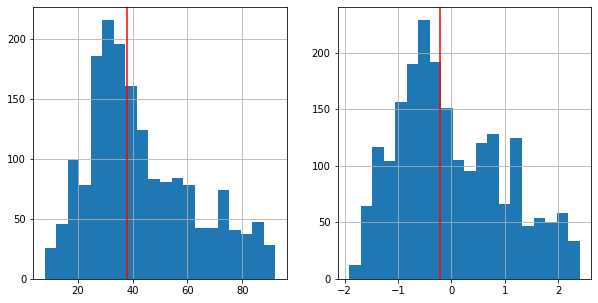

In [24]:


plt.rcParams['figure.figsize'] = [10, 5]
# create a subplot fitting two plots
fig, axes = plt.subplots(nrows=1, ncols=2)
# create the plots

hist1 = df_2012_.cpi.hist(bins=20, ax=axes[0])
hist1.axvline(df_2012_.cpi.median(), color="r")


hist2 = df_2012_.ci.hist(bins=20, ax=axes[1])
hist2.axvline(df_2012_.ci.median(), color="r")

similarities:  
overall shape, right-skewed, big spike in second quartile, few observations on the very corrupt end, more observations on the less corrupt end  

some differences I see in the plots:  
the World Bank CI looks more populated in the second quartile areas and has some additional non-corrup spikes


In [25]:
df_2012_

cpi        ci  population           gdp   inflation  \
country_code year                                                         
ABW          2012   NaN  1.095236    102112.0  25609.955724    0.168847   
             2013   NaN  1.119407    102880.0  26515.678080   -1.986755   
             2014   NaN  1.014232    103594.0  26942.307976    2.335109   
             2015   NaN  1.294156    104257.0  28421.386493    2.531592   
             2016   NaN  1.280407    104874.0  28451.273745   -1.389713   
...                 ...       ...         ...           ...         ...   
ZWE          2017  22.0 -1.281081  14751101.0   1192.107012    3.056905   
             2018  22.0 -1.227581  15052184.0   2269.177012  200.769578   
             2019  24.0 -1.273280  15354608.0   1421.868596  225.394648   
             2020  24.0 -1.289440  15669666.0   1372.696674  604.945864   
             2021  23.0 -1.257897  15993524.0   1773.920411  113.294981   

                   gov_debt_percent  primary_completion_percent  migration  \
country_code year                                                            
ABW          2012               NaN                         NaN      229.0   
             2013               NaN                   96.570641      134.0   
             2014               NaN                  101.180557       88.0   
             2015               NaN                         NaN      177.0   
             2016               NaN                         NaN      170.0   
...                             ...                         ...        ...   
ZWE          2017               NaN                   95.476372   -59918.0   
             2018               NaN                   92.195152   -59918.0   
             2019               NaN                   88.508812   -59918.0   
             2020               NaN                   90.017349   -29955.0   
             2021               NaN                   84.818619   -25005.0   

                   development_assistance_percent  interest_real  ...  \
country_code year                                                 ...   
ABW          2012                             NaN       8.217278  ...   
             2013                             NaN      10.699324  ...   
             2014                             NaN       4.851601  ...   
             2015                             NaN       4.358079  ...   
             2016                             NaN       8.406540  ...   
...                                           ...            ...  ...   
ZWE          2017                        4.654684       3.742846  ...   
             2018                        2.375721     -64.380817  ...   
             2019                        3.921986     -64.295151  ...   
             2020                        4.679008     -81.132121  ...   
             2021                             NaN     -31.795551  ...   

                   legal_rights_index  water_investment_total_abs  \
country_code year                                                   
ABW          2012                 NaN                         NaN   
             2013                 NaN                         NaN   
             2014                 NaN                         NaN   
             2015                 NaN                         NaN   
             2016                 NaN                         NaN   
...                               ...                         ...   
ZWE          2017                 5.0                         NaN   
             2018                 5.0                         NaN   
             2019                 6.0                         NaN   
             2020                 NaN                         NaN   
             2021                 NaN                         NaN   

                   wealth_highest_10_percent  wealth_lowest_10_percent  gini  \
country_code year                                                              
ABW          2012    

## Making some absolute stuff relative
filtering of data must be redone after this step
* GDP per capita instead of gdp
* migration per capita??
* grants in percent of gdp
* pregnant women receiving according medical attention  
* foreign direct investment in percent of gdp
* water investment in percent of gdp
* transport investment in percent of gdp


In [26]:
df_2012_["gdp_per_capita"] = df_2012_.gdp / df_2012_.population
df_2012_["net_migration_per_capita"] = df_2012_.migration / df_2012_.population
df_2012_["grants_non_tech_percent"] = df_2012_.grants_non_tech_abs / df_2012_.gdp
df_2012_["grants_tech_percent"] = df_2012_.grants_tech_abs / df_2012_.gdp
df_2012_["pregnant_healthcare_per_capita"] = df_2012_.pregnants_receiving_healthcare / df_2012_.population
df_2012_["foreign_direct_investment_percent"] = df_2012_.foreign_direct_investment_abs / df_2012_.gdp
df_2012_["water_investment_total_percent"] = df_2012_.water_investment_total_abs / df_2012_.gdp
df_2012_["transport_investment_percent"] = df_2012_.transport_investment_abs / df_2012_.gdp

df_2012_

<ipython-input-26-b4c78723949d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2012_["gdp_per_capita"] = df_2012_.gdp / df_2012_.population
<ipython-input-26-b4c78723949d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2012_["net_migration_per_capita"] = df_2012_.migration / df_2012_.population
<ipython-input-26-b4c78723949d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

cpi        ci  population           gdp   inflation  \
country_code year                                                         
ABW          2012   NaN  1.095236    102112.0  25609.955724    0.168847   
             2013   NaN  1.119407    102880.0  26515.678080   -1.986755   
             2014   NaN  1.014232    103594.0  26942.307976    2.335109   
             2015   NaN  1.294156    104257.0  28421.386493    2.531592   
             2016   NaN  1.280407    104874.0  28451.273745   -1.389713   
...                 ...       ...         ...           ...         ...   
ZWE          2017  22.0 -1.281081  14751101.0   1192.107012    3.056905   
             2018  22.0 -1.227581  15052184.0   2269.177012  200.769578   
             2019  24.0 -1.273280  15354608.0   1421.868596  225.394648   
             2020  24.0 -1.289440  15669666.0   1372.696674  604.945864   
             2021  23.0 -1.257897  15993524.0   1773.920411  113.294981   

                   gov_debt_percent  primary_completion_percent  migration  \
country_code year                                                            
ABW          2012               NaN                         NaN      229.0   
             2013               NaN                   96.570641      134.0   
             2014               NaN                  101.180557       88.0   
             2015               NaN                         NaN      177.0   
             2016               NaN                         NaN      170.0   
...                             ...                         ...        ...   
ZWE          2017               NaN                   95.476372   -59918.0   
             2018               NaN                   92.195152   -59918.0   
             2019               NaN                   88.508812   -59918.0   
             2020               NaN                   90.017349   -29955.0   
             2021               NaN                   84.818619   -25005.0   

                   development_assistance_percent  interest_real  ...  \
country_code year                                                 ...   
ABW          2012                             NaN       8.217278  ...   
             2013                             NaN      10.699324  ...   
             2014                             NaN       4.851601  ...   
             2015                             NaN       4.358079  ...   
             2016                             NaN       8.406540  ...   
...                                           ...            ...  ...   
ZWE          2017                        4.654684       3.742846  ...   
             2018                        2.375721     -64.380817  ...   
             2019                        3.921986     -64.295151  ...   
             2020                        4.679008     -81.132121  ...   
             2021                             NaN     -31.795551  ...   

                   military_expenses_percent  rd_expenses_percent  \
country_code year                                                   
ABW          2012                        NaN                  NaN   
             2013                        NaN                  NaN   
             2014                        NaN                  NaN   
             2015                        NaN                  NaN   
             2016                        NaN                  NaN   
...                                      ...                  ...   
ZWE          2017                   0.387831                  NaN   
             2018                   0.309323                  NaN   
             2019                   0.534804                  NaN   
             2020                   0.005400                  NaN   
             2021                   0.013530                  NaN   

                   gdp_per_capita  net_migration_per_capita  \
country_code year                                             
ABW          2012        0.250803                  0.00

In [27]:
df.loc["ARG", 2012]

cpi                               3.500000e+01
ci                               -4.459092e-01
population                        4.173327e+07
gdp                               1.308266e+04
inflation                         2.231488e+01
gov_debt_percent                           NaN
primary_completion_percent        1.033522e+02
migration                         3.127000e+03
development_assistance_percent    3.334436e-02
interest_real                    -6.748196e+00
grants_non_tech_abs               4.022000e+07
grants_tech_abs                   5.680000e+07
pregnants_receiving_healthcare    9.810000e+01
school_fm_ratio                   1.034610e+00
poverty_percent                   6.000000e-01
electricity_access_percent        9.922998e+01
foreign_direct_investment_abs     1.532393e+10
education_expenditure_percent     5.345830e+00
literacy_percent                  9.910523e+01
unemployment_percent              7.220000e+00
tertiary_enrollment_percent       7.744629e+01
tax_revenue_p

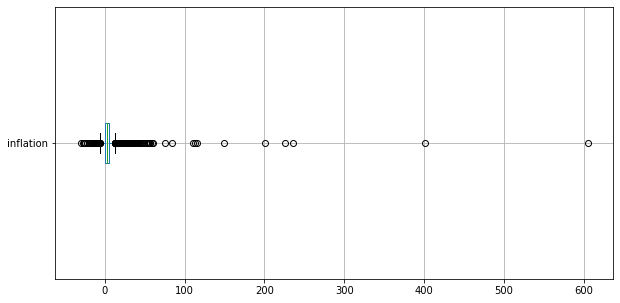

In [28]:
df_2012_.boxplot("inflation", vert=False)
# soooo where do we cut off inflation??

#### Variablen
full: alle daten, alle jahre, viele NAs bei dependent variables  
df: alle daten wo CI oder CPI nicht NA sind  
df_2012_: alle daten ab 2012 (ab da gibts den CPI)

In [29]:
# selecting only a handful of variables for starters
vars_y = ['cpi', 'ci']

vars_main = [
    'inflation', 'gov_debt_percent',
    'poverty_percent', 'unemployment_percent', 
    'tax_revenue_percent', 'legal_rights_index',
    'gini', 'gdp_per_capita',
       ]

vars_extra = [
    'interest_real', 'grants_non_tech_abs', 'grants_tech_abs', 
    'pregnants_receiving_healthcare', 'school_fm_ratio', 
    'electricity_access_percent', 'foreign_direct_investment_abs',
    'development_assistance_percent', 'education_expenditure_percent', 
    'literacy_percent', 'wealth_lowest_10_percent', 'wealth_highest_10_percent',
    'secure_servers_perml', 'transport_investment_abs', 'murders_p100k',
    'net_migration_per_capita', 'tertiary_enrollment_percent',
    'water_investment_total_abs', 'primary_completion_percent',
    'military_expenses_percent', 'rd_expenses_percent'
]
vars_drop = ['population', 'gdp', 'migration', 
            ]

In [30]:
df_2012_main = df_2012_[vars_main]
df_2012_main

inflation  gov_debt_percent  poverty_percent  \
country_code year                                                  
ABW          2012    0.168847               NaN              NaN   
             2013   -1.986755               NaN              NaN   
             2014    2.335109               NaN              NaN   
             2015    2.531592               NaN              NaN   
             2016   -1.389713               NaN              NaN   
...                       ...               ...              ...   
ZWE          2017    3.056905               NaN             34.2   
             2018  200.769578               NaN              NaN   
             2019  225.394648               NaN             39.8   
             2020  604.945864               NaN              NaN   
             2021  113.294981               NaN              NaN   

                   unemployment_percent  tax_revenue_percent  \
country_code year                                              
ABW          2012                   NaN                  NaN   
             2013                   NaN                  NaN   
             2014                   NaN                  NaN   
             2015                   NaN                  NaN   
             2016                   NaN                  NaN   
...                                 ...                  ...   
ZWE          2017                 4.785            15.874375   
             2018                 4.796             7.214765   
             2019                 4.833                  NaN   
             2020                 5.351                  NaN   
             2021                 5.174                  NaN   

                   legal_rights_index  gini  gdp_per_capita  
country_code year                                            
ABW          2012                 NaN   NaN        0.250803  
             2013                 NaN   NaN        0.257734  
             2014                 NaN   NaN        0.260076  
             2015                 NaN   NaN        0.272609  
             2016                 NaN   NaN        0.271290  
...                               ...   ...             ...  
ZWE          2017                 5.0  44.3        0.000081  
             2018                 5.0   NaN        0.000151  
             2019                 6.0  50.3        0.000093  
             2020                 NaN   NaN        0.000088  
             2021                 NaN   NaN        0.000111  

[2106 rows x 8 columns]

#### Filling NAs or dropping the rows with them???
in the next cell there is either the chance to drop the rows where the main variables are NA or to drop the rows with NAs

In [31]:
fillna = True
dropna = False
if fillna:
    df_2012_main = df_2012_main.fillna(method="ffill")
    df_2012_main = df_2012_main.fillna(method="bfill")
elif dropna:
    df_2012_main = df_2012_main.dropna()

df_2012_main

inflation  gov_debt_percent  poverty_percent  \
country_code year                                                  
ABW          2012    0.168847         63.669153             31.1   
             2013   -1.986755         63.669153             31.1   
             2014    2.335109         63.669153             31.1   
             2015    2.531592         63.669153             31.1   
             2016   -1.389713         63.669153             31.1   
...                       ...               ...              ...   
ZWE          2017    3.056905        103.698242             34.2   
             2018  200.769578        103.698242             34.2   
             2019  225.394648        103.698242             39.8   
             2020  604.945864        103.698242             39.8   
             2021  113.294981        103.698242             39.8   

                   unemployment_percent  tax_revenue_percent  \
country_code year                                              
ABW          2012                11.341             7.707801   
             2013                11.341             7.707801   
             2014                11.341             7.707801   
             2015                11.341             7.707801   
             2016                11.341             7.707801   
...                                 ...                  ...   
ZWE          2017                 4.785            15.874375   
             2018                 4.796             7.214765   
             2019                 4.833             7.214765   
             2020                 5.351             7.214765   
             2021                 5.174             7.214765   

                   legal_rights_index  gini  gdp_per_capita  
country_code year                                            
ABW          2012                 9.0  51.3        0.250803  
             2013                 9.0  51.3        0.257734  
             2014                 9.0  51.3        0.260076  
             2015                 9.0  51.3        0.272609  
             2016                 9.0  51.3        0.271290  
...                               ...   ...             ...  
ZWE          2017                 5.0  44.3        0.000081  
             2018                 5.0  44.3        0.000151  
             2019                 6.0  50.3        0.000093  
             2020                 6.0  50.3        0.000088  
             2021                 6.0  50.3        0.000111  

[2106 rows x 8 columns]

### Correlations

#### Correlations across time

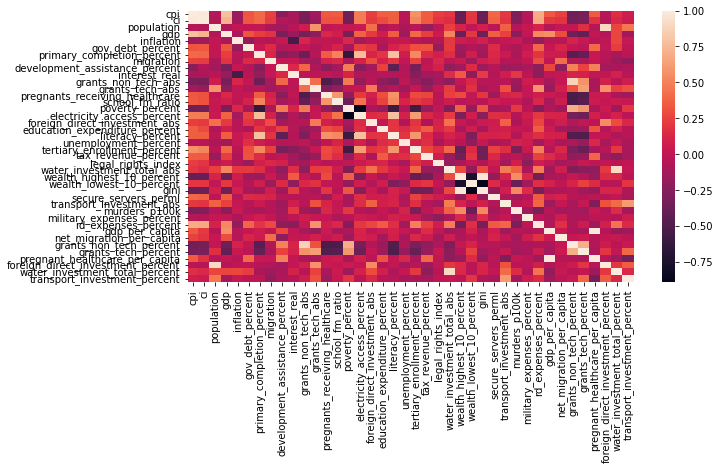

In [32]:
import seaborn as sns

sns.heatmap(df_2012_.corr(), xticklabels=df_2012_.columns, yticklabels=df_2012_.columns)

As we can see there are some notable correlations. It has to be noted tho that this correlations are caclulated not having filled the NAs

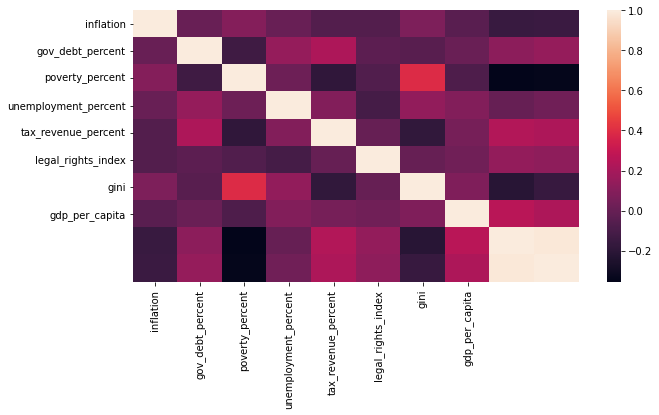

In [33]:
corr = df_2012_main.assign(cpi=df_2012_.cpi, ci=df_2012_.ci).corr()
sns.heatmap(corr, xticklabels=df_2012_main.columns, yticklabels=df_2012_main.columns)

After slecting specific columns and filling NAs we can see that there still are some correlations but they might be smaller.

# Model building

## Model selection

### Functions
Defineing some model selection fucntions with a usage example

In [34]:
from sklearn.model_selection import cross_val_score, KFold

def model_selection(X, y, models, cv=KFold(), scoring=None):
  named_models = [mt if type(mt).__name__ == 'tuple' else (mt.__class__.__name__,mt) for mt in models]
  return pd.DataFrame({name: cross_val_score(model, X, y, cv=cv, scoring=scoring) for name, model in named_models})

Example usage:

In [35]:
from sklearn import datasets, linear_model

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target
models = [('lasso', linear_model.Lasso()), linear_model.Ridge()]

lasso    0.337560
Ridge    0.410176
dtype: float64


,lasso,Ridge
0,0.283490,0.321664
1,0.351580,0.440484
2,0.353381,0.422105
3,0.334815,0.424664
4,0.364533,0.441962


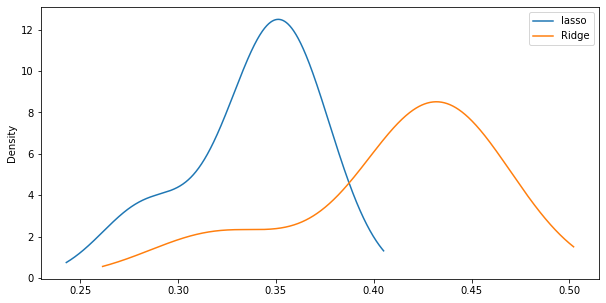

In [36]:
exmp_df = model_selection(X, y, models, scoring='r2')
print(exmp_df.mean())
exmp_df.plot.kde()
exmp_df

### Selection

### Corruption per country

#### Train test split

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_2012_main.loc(axis=0)[:,2018], df_2012_.loc(axis=0)[:,2018].cpi.fillna(0), test_size=0.33)

In [38]:
X_train.head()

,,inflation,gov_debt_percent,poverty_percent,unemployment_percent,tax_revenue_percent,legal_rights_index,gini,gdp_per_capita
country_code,year,,,,,,,,
DJI,2018,0.656016,90.403566,19.1,26.188999,10.548389,5.0,41.6,0.002607
HRV,2018,2.023500,89.451647,0.4,8.430000,21.504617,5.0,29.7,0.003729
BHS,2018,1.366284,56.783542,0.9,10.000000,14.390897,6.0,40.3,0.078969
TON,2018,5.139870,49.414605,1.1,3.070000,22.858362,10.0,37.6,0.044219
MLT,2018,2.189513,41.708394,0.1,3.660000,25.036418,2.0,28.7,0.065138


In [39]:
y_train.head()

country_code  year
DJI           2018    31.0
HRV           2018    48.0
BHS           2018    65.0
TON           2018     0.0
MLT           2018    54.0
Name: cpi, dtype: float64

In [40]:
from sklearn.tree import DecisionTreeRegressor
model_selection(X_train, y_train,[('decision_tree', DecisionTreeRegressor()), linear_model.Ridge()])

,decision_tree,Ridge
0,-0.422335,0.051409
1,-1.214197,0.038385
2,-0.230584,0.049343
3,-0.743597,-0.158764
4,-1.336102,0.209713


In [42]:
reg = DecisionTreeRegressor()
reg.fit(X_train,y_train)
y_pred_tree = reg.predict(X_test)

lasso   -0.011553
Ridge    0.038017
dtype: float64


,lasso,Ridge
0,0.038978,0.051409
1,-0.196804,0.038385
2,0.061506,0.049343
3,-0.137437,-0.158764
4,0.175991,0.209713


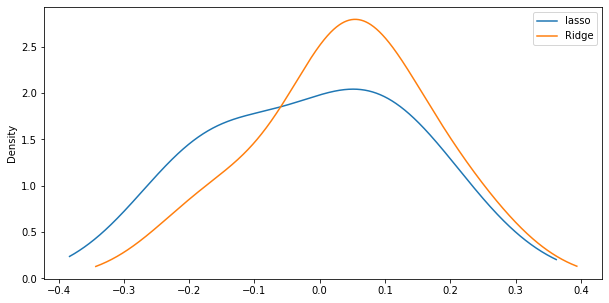

In [43]:
df_ = model_selection(X_train, y_train, models, scoring='r2')
print(df_.mean())
df_.plot.kde()
df_

In [46]:
y_pred_tree

array([30., 35., 35., 44., 61., 58., 60., 63., 16., 39.,  0., 81., 35.,
       58., 35., 68., 85., 29., 14., 87., 76., 52., 18.,  0., 66., 38.,
       27., 41., 33., 38.,  0., 49., 30., 35., 61., 66., 27., 60., 61.,
        0., 63., 19., 16., 43., 42., 35., 29., 36., 44., 35., 44., 26.,
       40., 36., 16., 35., 63., 26., 85., 16., 44., 16., 49., 31., 40.,
       43., 43., 35., 65., 58.])

### Corruption across time

#### Train test split

In [47]:
def get_train_test_split(X, y, year=2019):
  train = X.loc(axis=0)[:, :year].index
  return X.loc[train], X.drop(train), y.loc[train], y.drop(train)


X_train, X_test, y_train, y_test = get_train_test_split(df_2012_main, df_2012_.cpi.fillna(0))

In [48]:
X_train.isna().sum()

inflation               0
gov_debt_percent        0
poverty_percent         0
unemployment_percent    0
tax_revenue_percent     0
legal_rights_index      0
gini                    0
gdp_per_capita          0
dtype: int64

In [49]:
y_train.isna().sum()

0

In [50]:
from sklearn.tree import DecisionTreeRegressor
model_selection(X_train, y_train,[('decision_tree', DecisionTreeRegressor()), linear_model.Ridge()])

,decision_tree,Ridge
0,-1.030500,0.158384
1,-0.331211,0.095472
2,-0.755415,-0.817858
3,-0.481170,0.069431
4,-1.186999,-0.316125
